# DegreeDiscountIC (a.k.a the ORACLE)

In [18]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append(r"C:\Users\Tushar\Desktop\Sem 6\CS 726 Adv ML\Project Files\model-independent-cascade\src")
from influence import influence_count

Generating a random graph to test-run the model

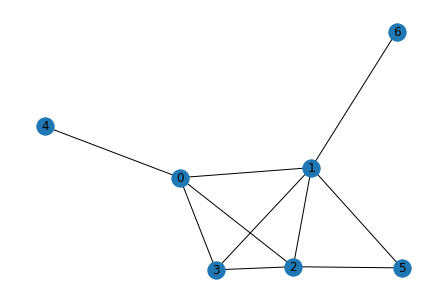

In [12]:
G = nx.graph_atlas(600)
nx.draw(G, with_labels=True)

In [6]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6))

In [9]:
def degdisIC(G, k):
    S = set({})
    temp = list(nx.degree(G))
    dd = d = [d for (_,d) in temp]
    t = [0 for i in range(len(d))]
    p = 0.01

    for _ in range(k):
        u = np.argmax(dd)
        dd[u] = -1
        S.add(u)
        neighbors = set(G.neighbors(u))
        for v in (neighbors-S):
            t[v] += 1
            dd[v] = d[v] - 2*t[v] - (d[v] - t[v])*t[v]*p

    return list(S)

In [14]:
degdisIC(G,1)

[1]

In [ ]:
influence_count()

In [21]:
list(G.edges()) + [(j,i) for (i,j) in list(G.edges())]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 5),
 (1, 6),
 (2, 3),
 (2, 5),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (2, 1),
 (3, 1),
 (5, 1),
 (6, 1),
 (3, 2),
 (5, 2)]